<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de bandido de k-brazos

### Resolución del Problema con Algoritmos Softmax

En este estudio, abordaremos el problema del bandido de k-brazos utilizando algoritmos Softmax. Este enfoque es una alternativa a los algoritmos epsilon-greedy y se basa en la probabilidad de seleccionar cada brazo en función de su valor estimado.

#### Algoritmos Softmax

A diferencia de los algoritmos epsilon-greedy, que seleccionan el mejor brazo conocido con una alta probabilidad y exploran otros brazos con una pequeña probabilidad, los algoritmos Softmax asignan una probabilidad a cada brazo basada en su valor estimado. Esto permite una exploración más equilibrada y puede mejorar el rendimiento en ciertos escenarios.

#### Objetivos del Estudio

En este estudio, compararemos el rendimiento de diferentes configuraciones del algoritmo Softmax en un entorno de bandido de 10 brazos. Para ello, realizaremos múltiples ejecuciones del experimento y generaremos las siguientes gráficas:

1. **Porcentaje de Selección del Brazo**: Mostraremos cómo varía el porcentaje de veces que cada brazo es seleccionado a lo largo del tiempo.
2. **Estadísticas de Cada Brazo**: Presentaremos el promedio de las ganancias obtenidas por cada brazo, lo que nos permitirá evaluar la efectividad de las selecciones.
3. **Evolución del Rechazo**: Analizaremos cómo evoluciona el rechazo acumulado (diferencia entre la recompensa óptima y la recompensa obtenida) a lo largo del tiempo.

Estas visualizaciones nos permitirán entender mejor el comportamiento de los algoritmos Softmax y su capacidad para equilibrar la exploración y la explotación en el problema del bandido de k-brazos.


## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [14]:
# !git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [ ]:
# %cd k_brazos_FJLGM

[WinError 2] El sistema no puede encontrar el archivo especificado: 'k_brazos_FJLGM'
c:\Users\Gonzalo\Documents\MASTER_IA\2_CUATRIMESTRE\EXTENSIONES_ML\Repos\RL-Bandido\k_brazos_FJLGM


c:\Users\Gonzalo\Documents\MASTER_IA\2_CUATRIMESTRE\EXTENSIONES_ML\Repos\RL-Bandido\k_brazos_FJLGM\.venv\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


### Librerías

In [2]:
import numpy as np
from typing import List

from src_algorithms import Algorithm, Softmax, GradientPreference
from src_arms import *
from src_plotting import *

Semilla:

In [3]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos Softmax con diferentes valores de temperatura. Se estudia la evolución de cada política en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [4]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))


    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100

    return rewards, optimal_selections

In [5]:
def run_experiment_complete(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm
    optimal_reward = bandit.arms[optimal_arm]# Obtener la recompensa esperada del brazo óptimo

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el rechazo acumulado.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Calcular el rechazo acumulado
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Calcular el rechazo acumulado promedio
    regret_accumulated = np.cumsum(regret_accumulated, axis=1) / runs

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats, regret_accumulated

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli de probabilidad **p**. 

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **Ascenso del gradiente**: 

- *Softmax*
- *Gradiente de preferencias*.

In [8]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [Softmax(k=k, tau=1),Softmax(k=k, tau=2.5), GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.4)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.25), ArmBernoulli(p=0.6), ArmBernoulli(p=0.45), ArmBernoulli(p=0.72), ArmBernoulli(p=0.73), ArmBernoulli(p=0.32), ArmBernoulli(p=0.74), ArmBernoulli(p=0.87), ArmBernoulli(p=0.8), ArmBernoulli(p=0.39)
Optimal arm: 8 with expected reward=0.87


En el contexto del problema del bandido de 10 brazos con distribución Bernoulli, cada brazo tiene una probabilidad asociada de proporcionar una recompensa de 1. En este caso, los brazos tienen las siguientes probabilidades de éxito.

El brazo óptimo es el que tiene la mayor probabilidad de éxito, en este caso, el brazo 8 con una probabilidad de 0.87. Esto significa que, en promedio, este brazo proporcionará una recompensa de 1 en el 87% de las veces que se seleccione.

*Consideraciones*: 

- Recompensas Menores a 1: Las recompensas promedio obtenidas por los algoritmos Softmax y Gradiente de Preferencias son menores a 1 debido a la naturaleza probabilística de las recompensas de los brazos Bernoulli. Incluso el brazo óptimo no garantiza una recompensa de 1 en cada intento, sino que tiene una probabilidad de 0.87 de proporcionar una recompensa de 1 y una probabilidad de 0.13 de proporcionar una recompensa de 0.

#### Algoritmos Softmax y Gradiente de Preferencias

Estos algoritmos están diseñados para equilibrar la exploración y la explotación. A lo largo de múltiples ejecuciones y pasos, los algoritmos intentan identificar el brazo óptimo, pero también exploran otros brazos para asegurarse de que no se pierdan posibles recompensas altas de otros brazos. Esta exploración adicional puede llevar a seleccionar brazos subóptimos en algunas ocasiones, lo que reduce la recompensa promedio observada. 

**Visualización de resultados**:

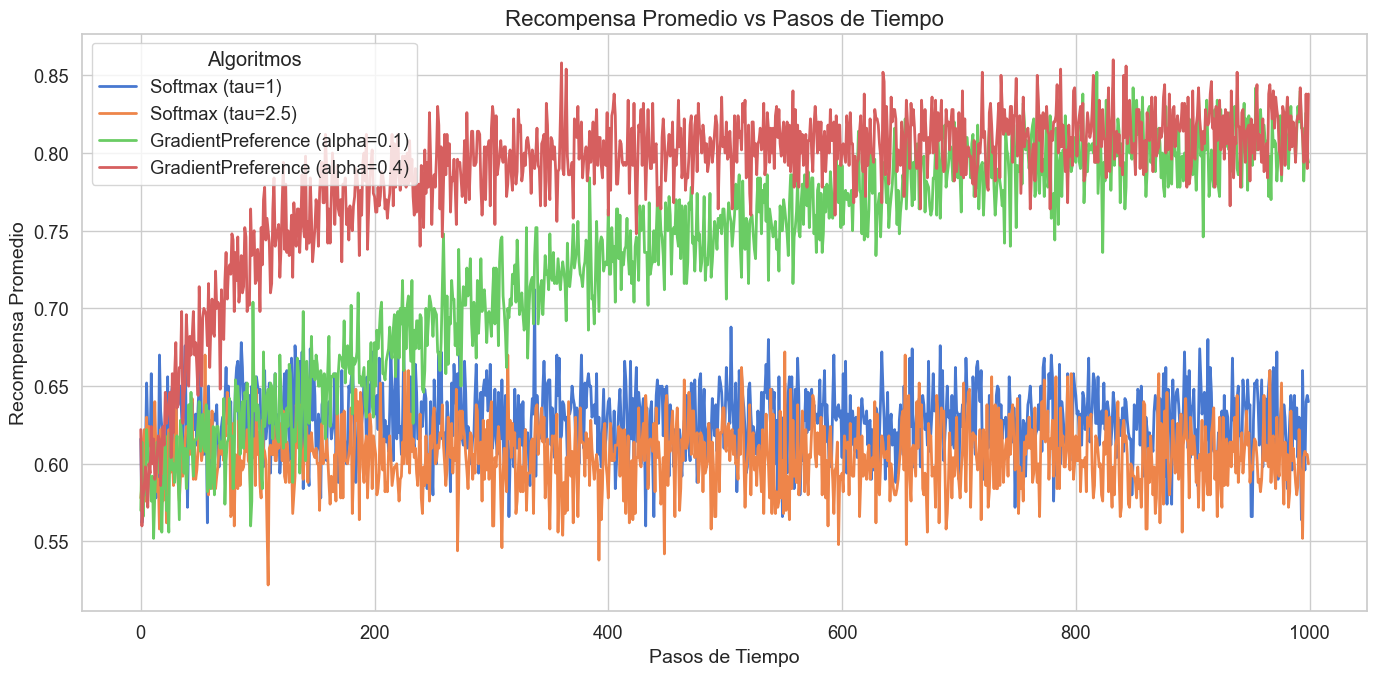

In [9]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

Para las diferentes configuraciones de los algoritmos:

- Azul (Softmax, τ = 1): Representa una estrategia Softmax con una temperatura de 1, lo que permite una exploración moderada.
- Naranja (Softmax, τ = 2.5): Representa una estrategia Softmax con una temperatura de 2.5, lo que permite una mayor exploración.
- Verde (Gradiente de Preferencias, α = 0.1): Representa una estrategia de Gradiente de Preferencias con una tasa de aprendizaje de 0.1.
- Rojo (Gradiente de Preferencias, α = 0.4): Representa una estrategia de Gradiente de Preferencias con una tasa de aprendizaje de 0.4.

**Crecimiento de la recompensa promedio:**

La línea roja (Gradiente de Preferencias, α = 0.4) alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con una mayor tasa de aprendizaje aprende más rápido qué brazos del bandit son óptimos.
La línea verde (Gradiente de Preferencias, α = 0.1) también muestra un crecimiento, pero más lento en comparación con α = 0.4.
Las líneas azul (Softmax, τ = 1) y naranja (Softmax, τ = 2.5) muestran un crecimiento más gradual, con la línea naranja alcanzando una recompensa promedio ligeramente mayor debido a una mayor exploración.

**Conclusiones**

Hemos estudiado un experimento de toma de decisiones secuenciales, modelado con un Multi-Armed Bandit (MAB) con distribución Bernoulli. Para este estudio nos hemos centrado en los algoritmos Softmax y Gradiente de Preferencias, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

1. Exploración vs Explotación

Los algoritmos Softmax y Gradiente de Preferencias equilibran la exploración y la explotación de diferentes maneras:

- Softmax: La temperatura τ controla el grado de exploración. Una temperatura más alta (τ = 2.5) permite una mayor exploración, mientras que una temperatura más baja (τ = 1) favorece la explotación.
- Gradiente de Preferencias: La tasa de aprendizaje α controla la rapidez con la que el algoritmo ajusta sus preferencias. Una tasa de aprendizaje más alta (α = 0.4) permite un ajuste más rápido y una mayor exploración inicial.

El gráfico confirma este comportamiento:

- Gradiente de Preferencias con α = 0.4 (rojo) obtiene la mejor recompensa promedio a lo largo del tiempo porque ajusta rápidamente sus preferencias y explora lo suficiente como para encontrar rápidamente el mejor brazo.
- Gradiente de Preferencias con α = 0.1 (verde) explora menos, por lo que tarda más en converger a una recompensa alta.
- Softmax con τ = 2.5 (naranja) explora más que Softmax con τ = 1 (azul), lo que le permite encontrar mejores brazos, pero a un ritmo más lento que el Gradiente de Preferencias con α = 0.4.

2. Convergencia de los algoritmos

Los algoritmos con mayor exploración (Gradiente de Preferencias con α = 0.4 y Softmax con τ = 2.5) alcanzan una recompensa alta más rápido. Esto se debe a que:

- Al principio, el algoritmo no tiene información suficiente sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un balance entre exploración y explotación es clave para maximizar la recompensa a largo plazo.

3. Aplicaciones y conclusiones

En problemas de toma de decisiones (ejemplo: recomendaciones, optimización de anuncios, medicina personalizada), una estrategia de exploración moderada como Gradiente de Preferencias con α = 0.4 es más efectiva para encontrar la mejor opción rápidamente.
La falta de exploración (Softmax con τ = 1) lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.


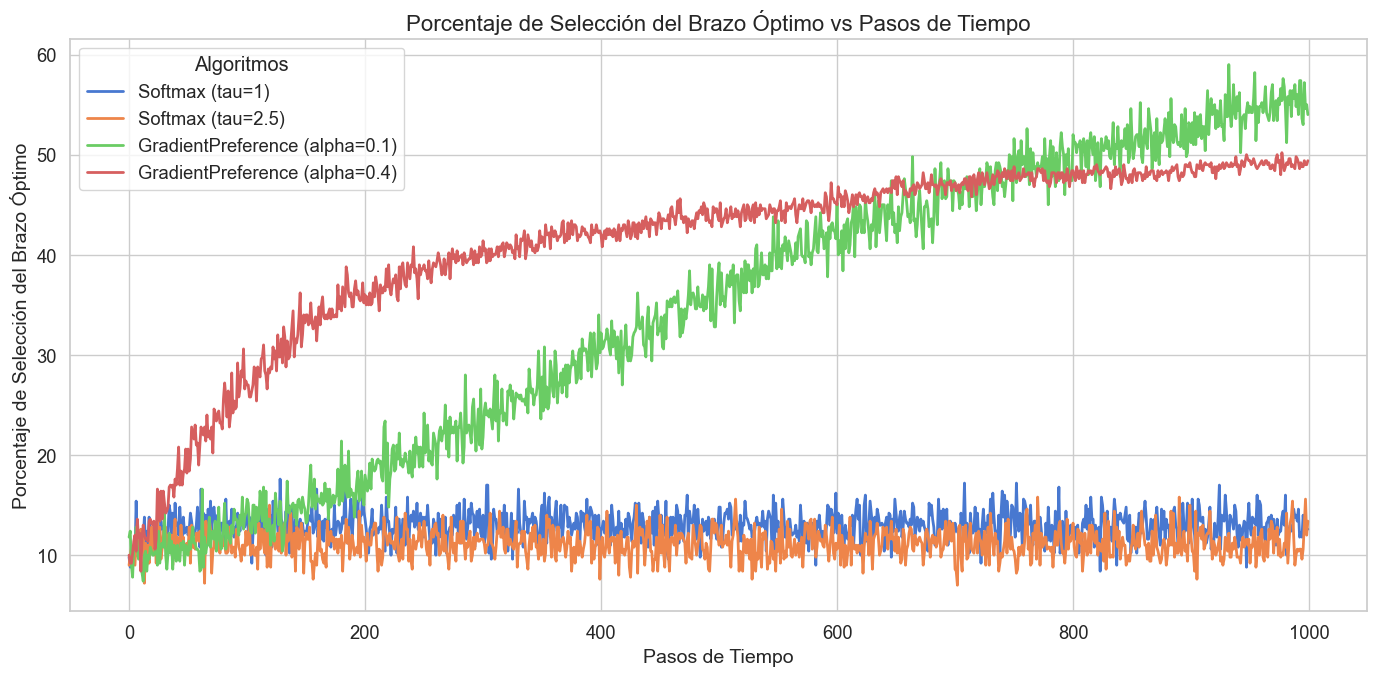

In [10]:
plot_optimal_selections(steps, optimal_selections, algorithms)